In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from feos.si import *
from feos.eos import *
from feos.uvtheory import *

## **uv-theory for Monomer mixtures**
$a = a_d^\text{hs}+\Delta a_0 + \Delta a_1^u + \sum_i \sum_j x_i x_j \psi_{ij}(\Delta B_{2,ij} - \Delta B_{21, ij}^u)$
with

 1.  ArithmetricPhi: $\psi_{ij} = 1 - \phi_{ij}^u$ and $\phi_{ij}^u=0.5(\phi_{ii} + \phi_{jj})$
 2. GeometricPhi: $\psi_{ij} = 1 - \phi_{ij}^u$ and $\phi_{ij}^u=\sqrt{\phi_{ii}  \phi_{jj}}$
 3. GeometricPsi: $\psi_{ij} = \sqrt{(1 - \phi_{ii})(1- \phi_{jj}) }$
 4. OneFluidPsi: $\psi_{ij} = \psi_{x} =1 - \phi_{x}(\rho_x,T_x, m_x)$
 
For geometric averages: Values in the square root must not become negtive!!!

In [6]:
# Test LJ CP
m = 1
rep = 12
att = 6
eps_k = 10
sigma = 10
params = UVParameters.new_simple(m, rep, att, sigma, eps_k)
uv_bh_pure = EquationOfState.uvtheory(params, perturbation=Perturbation.BarkerHenderson)
State.critical_point(uv_bh_pure)

|temperature|density|
|-|-|
|13.14648 K|522.80000  mol/m³|

In [7]:
uv_bh_pure = EquationOfState.uvtheory(params, perturbation=Perturbation.WeeksChandlerAndersen)
State.critical_point(uv_bh_pure)

|temperature|density|
|-|-|
|13.09766 K|502.02379  mol/m³|

In [8]:
m = [1, 1]
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 1.5])
eps_k = np.array([1.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)


In [9]:
data_vrabec = {
    'T': [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    'x1': [0.00000, 0.10156, 0.30078, 0.50000, 0.69922, 0.90000, 1.00000],
    'y1': [0.00000, 0.1934, 0.4889, 0.705, 0.8707, 0.9713, 1.00000],
    'p': [0.00742, 0.00815, 0.01056, 0.01347, 0.01675, 0.02196, 0.02505],
    'uncert_p': [7, 18, 22, 23, 26, 41, 22],
    'rho_l': [0.70081, 0.69236, 0.68394, 0.67859, 0.67993, 0.68930, 0.70081],
    'uncert_rhol': [38, 96, 90, 83, 87, 12, 38],
    'rho_v': [0.02964, 0.02698, 0.02556, 0.02482, 0.02404, 0.02698, 0.02964],
    'uncert_rhov': [32, 74, 67, 56, 48, 61, 32]
}

df_vrabec = pd.DataFrame(data_vrabec)

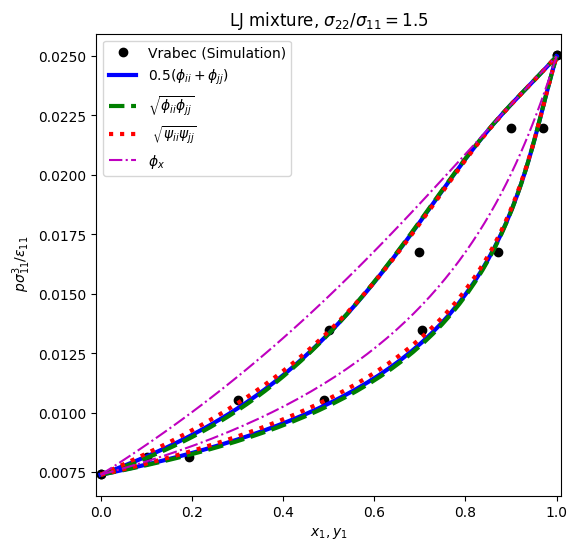

In [10]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(-0.01,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 1.5$')



ax.plot(data_vrabec['x1'] , data_vrabec['p'], 'ko', label='Vrabec (Simulation)')
ax.plot(data_vrabec['y1'] , data_vrabec['p'], 'ko')

#plt.plot(df['x1'], df['p'], 'b-', label='One Fluid u-fraction  $\\phi_x$')
#plt.plot(df['y1'], df['p'], 'b')



ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')

ax.legend()

In [11]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 1.0])
eps_k = np.array([1.0, 0.50])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

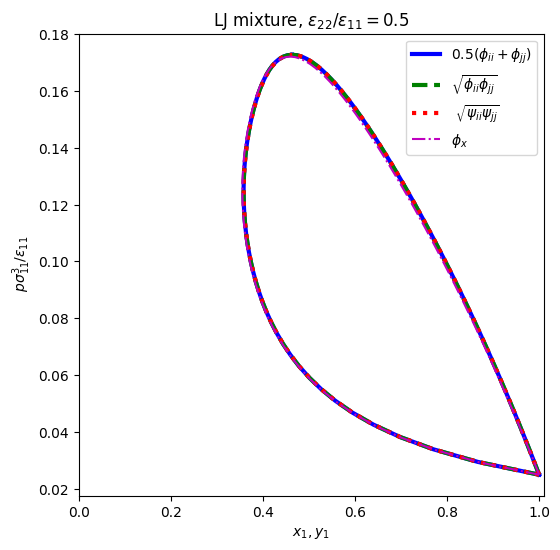

In [12]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\varepsilon_{22} / \\varepsilon_{11} = 0.5$')



ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')


ax.legend()


In [13]:
data_sig2_sig1_05 = {
    'T': [1.00,1.00,1.00,1.00,1.00,1.00,1.00],
    
    'p':[0.03085,0.04,	0.05	,0.075	,0.1,0.125	,0.15,	    ],
    'x1':[0.87515336,0.7488606,0.63339615,0.4365508,0.27925158,0.19074777,0.11091277,],
    'x2':[0.68014145,0.48342085,0.34628806,0.14998586,0.051191095,0.03581933,0.013405361,     
    ]
} # referemce data Harismiadis

df1 = pd.DataFrame(data_sig2_sig1_05)

In [14]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([3, 1.5])
eps_k = np.array([120.0, 120.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN, npoints=70)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

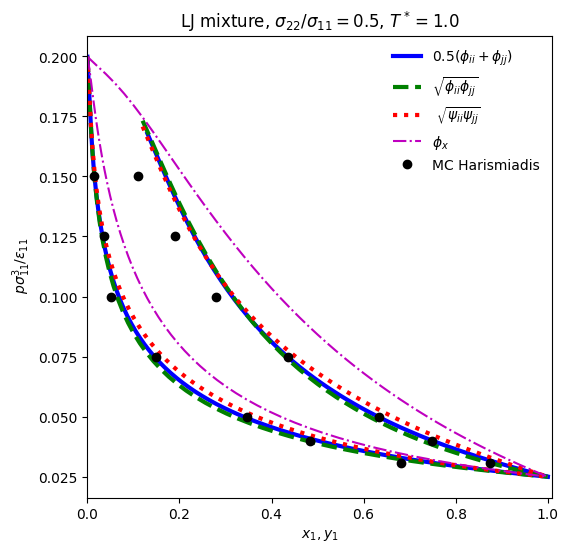

In [15]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')




plt.plot(df1['x1'], df1['p'], 'ko', label='MC Harismiadis')
plt.plot(df1['x2'], df1['p'], 'ko')
plt.legend(frameon=False)

In [16]:
data = [
    [1.00, 0.05, 0.92008126, 0.5568408],
    [1.00, 0.1, 0.78524196, 0.28388235],
    [1.00, 0.2, 0.61616147, 0.15504083],
    [1.00, 0.35, 0.42643267, 0.082767725],
    [1.00, 0.5, 0.32370824, 0.06541605],
    [1.00, 0.7, 0.22806972, 0.08016359],
    [1.00, 0.9, 0.12971175, 0.09164759]
]

df2 = pd.DataFrame(data, columns=['T*', 'p*', 'x1', 'x2'])
#print(df2)

In [17]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 0.5])
eps_k = np.array([2.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)

eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.BarkerHenderson,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.BarkerHenderson, combination_rule=CombinationRule.OneFluidPsi)

In [18]:
dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN, npoints=70)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

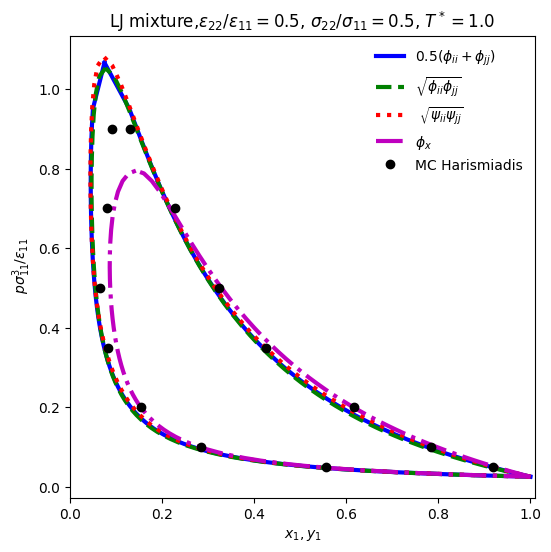

In [19]:
f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture,$\\varepsilon_{22} / \\varepsilon_{11} = 0.5$, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', linewidth=3, label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', linewidth=3)


plt.plot(df2['x1'], df2['p*'], 'ko', label='MC Harismiadis')
plt.plot(df2['x2'], df2['p*'], 'ko')
plt.legend(frameon=False)

## Weeks-Chandler-Andersen Division

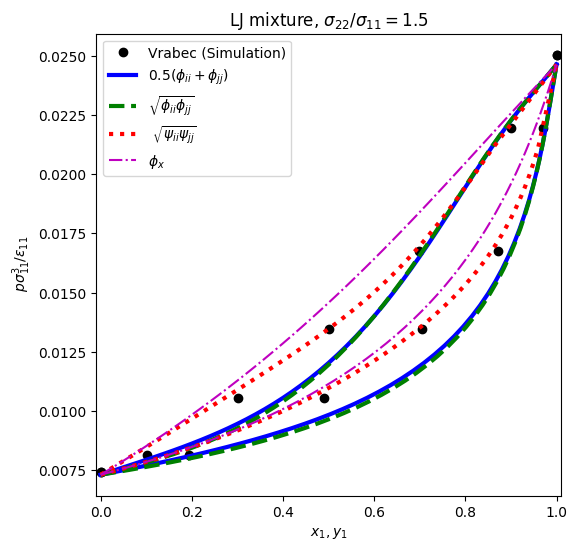

In [20]:
m = [1, 1]
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 1.5])
eps_k = np.array([1.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.WeeksChandlerAndersen,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)


f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(-0.01,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 1.5$')



ax.plot(data_vrabec['x1'] , data_vrabec['p'], 'ko', label='Vrabec (Simulation)')
ax.plot(data_vrabec['y1'] , data_vrabec['p'], 'ko')

#plt.plot(df['x1'], df['p'], 'b-', label='One Fluid u-fraction  $\\phi_x$')
#plt.plot(df['y1'], df['p'], 'b')



ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')

ax.legend()


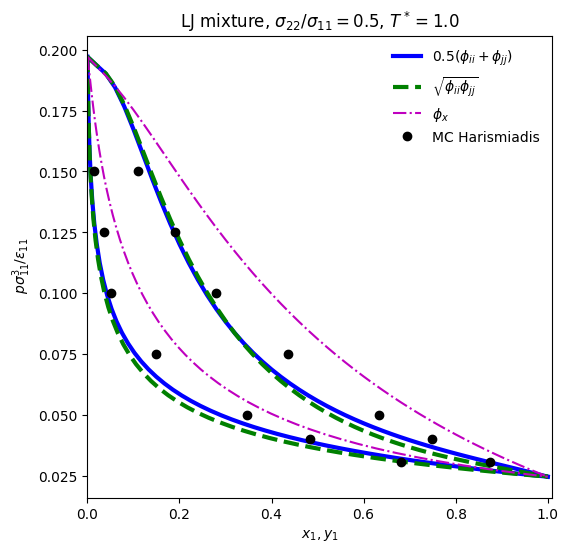

In [25]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([3, 1.5])
eps_k = np.array([120.0, 120.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.WeeksChandlerAndersen,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

#ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
#ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')




plt.plot(df1['x1'], df1['p'], 'ko', label='MC Harismiadis')
plt.plot(df1['x2'], df1['p'], 'ko')
plt.legend(frameon=False)

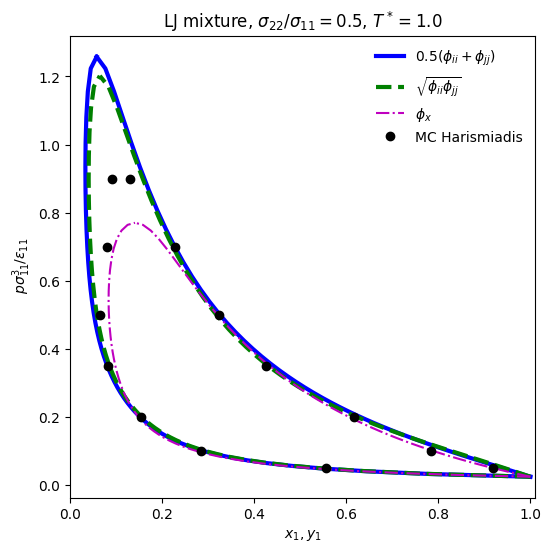

In [24]:
# Second example from uv-paper:
rep = np.array([12.0, 12.0])
att = np.array([6.0, 6.0])
sigma = np.array([1.0, 0.5])
eps_k = np.array([2.0, 1.0])

params = UVParameters.new_simple_binary(m, rep, att, sigma, eps_k)
eos_1 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second, perturbation=Perturbation.WeeksChandlerAndersen,  combination_rule=CombinationRule.ArithmeticPhi)
eos_2 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPhi)
eos_3 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.GeometricPsi)
eos_4 = EquationOfState.uvtheory(params, virial_order=VirialOrder.Second,  perturbation=Perturbation.WeeksChandlerAndersen, combination_rule=CombinationRule.OneFluidPsi)

dia_p_rust_1 = PhaseDiagram.binary_vle(eos_1, eps_k[0] * KELVIN)#, verbosity=Verbosity.Iter)
dia_p_rust_2 = PhaseDiagram.binary_vle(eos_2, eps_k[0] * KELVIN)
#dia_p_rust_3 = PhaseDiagram.binary_vle(eos_3, eps_k[0] * KELVIN)
dia_p_rust_4 = PhaseDiagram.binary_vle(eos_4, eps_k[0] * KELVIN)

f, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim(0,1.01)
ax.set_xlabel('$x_1,y_1$')
ax.set_ylabel(' $p\\sigma_{11}^3 / \\varepsilon_{11}$')
ax.set_title('LJ mixture, $\\sigma_{22} / \sigma_{11} = 0.5$, $T^*=1.0$')

ax.plot(dia_p_rust_1.liquid.molefracs[:,0],dia_p_rust_1.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, linewidth=3, color='blue', label='$0.5(\phi_{ii}+\phi_{jj})$')
ax.plot(dia_p_rust_1.vapor.molefracs[:,0],dia_p_rust_1.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '-', linewidth=3, color='blue')

ax.plot(dia_p_rust_2.liquid.molefracs[:,0],dia_p_rust_2.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3, label='$\\sqrt{\phi_{ii}\phi_{jj}}$')
ax.plot(dia_p_rust_2.vapor.molefracs[:,0],dia_p_rust_2.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, '--g', linewidth=3)

#ax.plot(dia_p_rust_3.liquid.molefracs[:,0],dia_p_rust_3.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3, label=' $\\sqrt{\psi_{ii}\psi_{jj}}$')
#ax.plot(dia_p_rust_3.vapor.molefracs[:,0],dia_p_rust_3.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'r:', linewidth=3)

ax.plot(dia_p_rust_4.liquid.molefracs[:,0],dia_p_rust_4.liquid.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.', label='$\\phi_x$')
ax.plot(dia_p_rust_4.vapor.molefracs[:,0],dia_p_rust_4.vapor.pressure / (KB * eps_k[0] * KELVIN) * (sigma[0] * ANGSTROM)**3, 'm-.')




plt.plot(df2['x1'], df2['p*'], 'ko', label='MC Harismiadis')
plt.plot(df2['x2'], df2['p*'], 'ko')
plt.legend(frameon=False)